# 実習の説明

## これは何か？

Jupyter notebook というRを使うためのインターフェースの一つです。

- Jupyter notebook の簡単な説明（日本語） https://datumstudio.jp/blog/795

特に、今回は JupyterHub という形で（みなさんの手元のPCではなく）オンラインでJupyter notebookを使う環境を提供しています。
これは、講義などで同一の環境でできるのに便利です。


## 何をするか？

非小細胞肺癌 (non-small-cell lung cancer; NSCLC) において、腫瘍組織内に存在する間質細胞から腫瘍細胞にシグナルのクロストークが送って腫瘍が活性化される可能性を探ります。データは、NSCLCモデルマウスと野生型のマウスの肺から、セルソーターで分けたマクロファージ、単球細胞、好中球、上皮細胞のRNA-seqデータです。

> このようなRNA-seqデータを、「変数が全遺伝子、条件が細胞型xマウス（野生型 or 腫瘍）、値が発現量である表」として想像できると、あとの解析がスムーズです

元ネタはこちら: 

- Toi _et al_., Transcriptome Analysis of Individual Stromal Cell Populations Identifies Stroma-Tumor Crosstalk in Mouse Lung Cancer Model, Cell Reports (2015) http://dx.doi.org/10.1016/j.celrep.2015.01.040 

ソフトウェアやアノテーションデータが著者らのウェブページで公開されています。また、NGSデータの生データや処理済みデータはGene Expression Omnibus (GEO)より公開されています。

- ソフトウェアやアノテーションデータ http://209.160.41.231/u54/CCCExplorer/
- Gene Expression Omnibus (GEO)のNGSデータのページ https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE59831

## どうやるか？

腫瘍組織内間質細胞のリガンドから腫瘍細胞の受容体へのシグナルのクロストークがあるとしたら、

- 腫瘍モデルマウスでは野生型に比べ、リガンドが発現上昇しているだろう
- 腫瘍モデルマウスの上皮組織では、そのリガンドの受容体が発現しているだろう

そのようなリガンドと受容体のペアを見つけるのに必要なデータは？

- 既知のリガンド-受容体ペアのデータベース（ヒト）
- ヒト-マウスオーソログの対応表
- 腫瘍組織内間質細胞で発現上昇がみられた遺伝子のリスト
- 腫瘍細胞で発現上昇

それらのデータを組み合わせればよさそう

![image.png](https://ars.els-cdn.com/content/image/1-s2.0-S2211124715000650-fx1.jpg)
(Image from http://dx.doi.org/10.1016/j.celrep.2015.01.040)

# 練習

## ライブラリのロード
ライブラリを使えるようにするためにロードする

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math

## Google Drive をマウントする

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/3wFf1_cKRVHEzh-K9QBU1mp9zhj0AopLVNqqhPmJXB-OFkohjlwkXHQ
Mounted at /content/drive


## 遺伝子発現変動解析の結果のデータを眺めてみる

遺伝子はたくさんありますが、その中でも、「発現量がサンプル間で変動している遺伝子」に注意が向きます。なぜなら、そのような遺伝子は、サンプル間の表現型の違いを説明する可能性があるからです。

そのような遺伝子は一般に発現変動遺伝子（Differentially expressed genes; DEG） と呼ばれます。

ここでは正常組織と腫瘍組織のマクロファージの発現変動遺伝子解析の結果のデータを読み込んで、値の分布などを調べます。

- 詳しく言うと、正常組織と腫瘍組織のマクロファージから取得した RNA-seq データから、正常組織と腫瘍組織の間で発現が変動しているかを全ての遺伝子について網羅的に仮説検定した結果のデータ (`data/CCCExplorer/CD11CB_output/gene_exp.diff`) です。
 
これを例に、データの眺め方をみていきます。

In [3]:
# データの読み込み
deg_macrophage = pd.read_csv("/content/drive/My Drive/2020 L-1　情報科学・数理科学を用いた医学研究/07/data/CCCExplorer/CD11CB_output/gene_exp.diff", sep="\t")

In [4]:
# 行数、何数を調べる
deg_macrophage.shape

(30743, 14)

In [5]:
# データの頭の部分だけ確認
deg_macrophage.head()

,test_id,gene_id,gene,locus,sample_1,sample_2,status,value_1,value_2,log2(fold_change),test_stat,p_value,q_value,significant
0,0610005C13Rik,0610005C13Rik,-,chr7:45567794-45589710,q1,q2,NOTEST,0.072521,0.044282,-0.711684,0.000000,1.00000,1.000000,no
1,0610007C21Rik,0610007C21Rik,-,chr5:31036035-31054623,q1,q2,OK,50.268700,47.849600,-0.071153,-0.229939,0.71855,0.839597,no
2,0610007N19Rik,0610007N19Rik,-,chr15:32240567-32244662,q1,q2,NOTEST,0.238515,0.062952,-1.921740,0.000000,1.00000,1.000000,no
3,0610007P08Rik,0610007P08Rik,-,chr13:63815319-63900301,q1,q2,OK,3.574360,3.112430,-0.199643,-0.579890,0.36160,0.542589,no
4,0610007P14Rik,0610007P14Rik,-,chr12:85815454-85824545,q1,q2,OK,11.635600,10.572300,-0.138247,-0.474073,0.54570,0.711416,no


実はこのようなデータでした

- 縦に遺伝子名のようなものが並んでいる。各行が遺伝子、各列が変数になっている
- `p_value`や`q_value`は発現変動を判定する統計検定の結果だろう
- `log2(fold_change)` は `value_2`/`value_1`をlog2変換したものだろう
    - ちなみに、`value_1` は正常組織でのマクロファージ、 `value_2` は腫瘍組織内マクロファージ (intratumoral macropahges)でのFPKMの平均値
      - これは __メタデータ__ をみないとわからない

In [6]:
# 使いやすいように、使いたい列だけにする
deg_macrophage = deg_macrophage[['gene_id', 'value_1', 'value_2', 'log2(fold_change)', 'p_value', 'q_value']]

In [7]:
# データの形が変わったことを確認
deg_macrophage.head()

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value
0,0610005C13Rik,0.072521,0.044282,-0.711684,1.00000,1.000000
1,0610007C21Rik,50.268700,47.849600,-0.071153,0.71855,0.839597
2,0610007N19Rik,0.238515,0.062952,-1.921740,1.00000,1.000000
3,0610007P08Rik,3.574360,3.112430,-0.199643,0.36160,0.542589
4,0610007P14Rik,11.635600,10.572300,-0.138247,0.54570,0.711416


(array([ 6594.,  1334.,  1079.,   870.,   804.,   731.,   723.,   723.,
          774., 17111.]),
 array([5.00000e-05, 1.00045e-01, 2.00040e-01, 3.00035e-01, 4.00030e-01,
        5.00025e-01, 6.00020e-01, 7.00015e-01, 8.00010e-01, 9.00005e-01,
        1.00000e+00]),
 <a list of 10 Patch objects>)

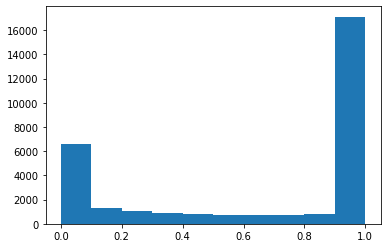

In [8]:
# p-valueの分布を確認する
plt.hist(deg_macrophage['p_value'])

(array([ 5328.,  1090.,   927.,   926.,   928.,   850.,   834.,  1008.,
         1083., 17769.]),
 array([3.10039000e-04, 1.00279035e-01, 2.00248031e-01, 3.00217027e-01,
        4.00186023e-01, 5.00155019e-01, 6.00124016e-01, 7.00093012e-01,
        8.00062008e-01, 9.00031004e-01, 1.00000000e+00]),
 <a list of 10 Patch objects>)

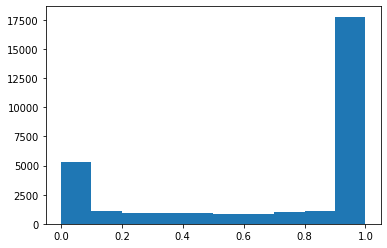

In [9]:
# q-valueの分布を確認する
plt.hist(deg_macrophage['q_value'])

(array([2.0000e+00, 4.0000e+00, 4.1000e+01, 6.8800e+02, 2.3905e+04,
        3.6710e+03, 3.5700e+02, 3.4000e+01, 1.0000e+00, 2.0000e+00]),
 array([-14.2799 , -11.30814,  -8.33638,  -5.36462,  -2.39286,   0.5789 ,
          3.55066,   6.52242,   9.49418,  12.46594,  15.4377 ]),
 <a list of 10 Patch objects>)

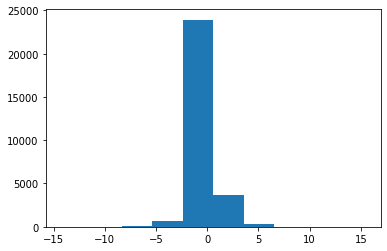

In [20]:
# `log2(fold_change)`の分布を確認する
plt.hist(
    # inf や -inf があると、うまく描画できなかったので、 `np.isfinite()` で有限な値の行のみにしている
    deg_macrophage[np.isfinite(deg_macrophage['log2(fold_change)'])]['log2(fold_change)']
)

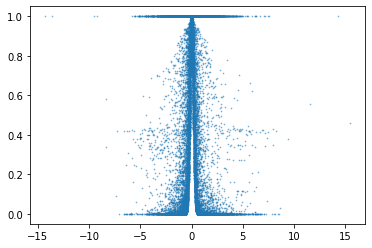

In [21]:
# log2FC と q_valueの関係を眺めてみる (volcano plot)
plt.scatter(deg_macrophage['log2(fold_change)'], deg_macrophage['q_value'], s = 0.5, alpha = 0.5)

## 発現変動遺伝子の数を数える

遺伝子はたくさんありますが、その中でも、「発現量がサンプル間で変動している遺伝子」に注意が向きます。なぜなら、そのような遺伝子は、サンプル間の表現型の違いを説明する可能性があるからです。

そのような遺伝子は一般に発現変動遺伝子（Differentially expressed genes; DEG） と呼ばれます。ここでは、発現変動遺伝子を抽出することを試みます。



In [25]:
# Fold change (fc) と　q-value (qv) の閾値を設定する

threshold_fc = math.log2(1.5)
threshold_qv = 0.1 

In [26]:
# 腫瘍組織内マクロファージで多い (FC > 1.5, q_value < 0.1) 遺伝子の数は？
deg_macrophage.query('`log2(fold_change)` > @threshold_fc & q_value < @threshold_qv').shape

(2324, 6)

In [27]:
# 正常組織内マクロファージで多い (FC > 1/1.5, q_value < 0.1) の遺伝子の数は？
deg_macrophage.query('`log2(fold_change)` > -1 * @threshold_fc & q_value < @threshold_qv').shape

(3334, 6)

## ポジコンが取れているかを確認する
一般に実験がうまくいったかを確認するためには、「その実験がうまくいっているとすると絶対に観察される結果」を事前に設定します。これをポジコン（Positive control）と呼びます。

RNA-seq解析では、「このサンプルだとこの遺伝子は絶対に出ているはず」「この２サンプル群間でこの遺伝子は絶対に発現量に差が出ているはず」という遺伝子がポジコンに当たります。

今回は、「腫瘍内マクロファージでは、正常組織でのマクロファージに比べ、MMP-9やVEGFA遺伝子の発現量が高くなっている」という先行研究を参照し（下記）、これらの遺伝子が「腫瘍内マクロファージで高いと判定される発現変動遺伝子」に含まれるかを確認します。これにより、このRNA-seqデータが、生物学的なシグナルを反映してるかを判断します。


> "intratumoral macrophages express increased cathepsin K, COX-2, MMP-9, PDGF-B, uPA, VEGFA, and HGF (Wang et al., 2011)"
    - Wang et al., 2011 http://www.sciencedirect.com/science/article/pii/S0169500211002546

In [28]:
# ポジコンである Vegfa がとれるかの確認 (生物学的なQC)
deg_macrophage.query('`log2(fold_change)` > @threshold_fc & q_value < @threshold_qv').query('gene_id=="Vegfa"')

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value
29378,Vegfa,7.99474,167.936,4.39272,0.00005,0.00031


In [29]:
# ポジコンである Mmp9 がとれるかの確認 (生物学的なQC)
deg_macrophage.query('`log2(fold_change)` > @threshold_fc & q_value < @threshold_qv').query('gene_id=="Mmp9"')

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value
20560,Mmp9,0.088896,6.75021,6.24667,0.00005,0.00031


------

------

------


# 本番

## 腫瘍組織内間質細胞で発現上昇する遺伝子のリストを得る

In [30]:
# 発現量（Expression, ex） の閾値
threshold_ex = 2

In [31]:
# とある条件で腫瘍組織内間質細胞で発現上昇する遺伝子をフィルタリング
deg_macrophage_tumor = deg_macrophage.query('value_2 > @threshold_ex & `log2(fold_change)` > @threshold_fc & q_value < @threshold_qv')

# 何行 (何遺伝子)
deg_macrophage_tumor.shape

(1921, 6)

## 腫瘍細胞で発現する遺伝子のリストを得る


In [32]:
# 遺伝子発現量 (FPKM) をまとめた表を読み込む (Cufflinksの出力だとおもう)
fpkm_epi = pd.read_csv('/content/drive/My Drive/2020 L-1　情報科学・数理科学を用いた医学研究/07/data/CCCExplorer/EP_output/genes.read_group_tracking', sep="\t")

In [33]:
# 行数、何数を調べる
fpkm_epi.shape

(184458, 9)

In [34]:
# データの頭の部分だけ確認
fpkm_epi.head()

,tracking_id,condition,replicate,raw_frags,internal_scaled_frags,external_scaled_frags,FPKM,effective_length,status
0,0610005C13Rik,q1,1,11.0,12.99970,12.99970,0.499583,-,OK
1,0610005C13Rik,q1,0,3.0,4.10373,4.10373,0.122142,-,OK
2,0610005C13Rik,q1,2,0.0,0.00000,0.00000,0.000000,-,OK
3,0610005C13Rik,q2,1,14.0,12.69620,12.69620,0.377883,-,OK
4,0610005C13Rik,q2,0,12.0,8.66261,8.66261,0.257830,-,OK


In [35]:
# 使いやすいように、使いたい列だけにする
fpkm_epi = fpkm_epi[['tracking_id', 'FPKM']]

fpkm_epi.head()

,tracking_id,FPKM
0,0610005C13Rik,0.499583
1,0610005C13Rik,0.122142
2,0610005C13Rik,0.000000
3,0610005C13Rik,0.377883
4,0610005C13Rik,0.257830


In [36]:
# とある条件で腫瘍細胞で発現する遺伝子をフィルタリング
fpkm_epi_tumor = fpkm_epi.query('FPKM > @threshold_ex')

fpkm_epi_tumor.shape

(72437, 2)

## ヒト-マウスのオーソログ関係の取得

`data/CCCExplorer/HOM_MouseHumanSequence.rpt` は Mouse Genome Informatics database から取得されたヒト-マウスオーソログリスト

In [37]:
# データの読み込み
dfhom = pd.read_csv('/content/drive/My Drive/2020 L-1　情報科学・数理科学を用いた医学研究/07/data/CCCExplorer/HOM_MouseHumanSequence.rpt', sep="\t")

# 何行何列
dfhom.shape

(39522, 13)

In [38]:
# データの頭をみる
dfhom.head()

,HomoloGene ID,Common Organism Name,NCBI Taxon ID,Symbol,EntrezGene ID,Mouse MGI ID,HGNC ID,OMIM Gene ID,Genetic Location,"Genomic Coordinates (mouse: GRCm38, human: GRCh37.p10)",Nucleotide RefSeq IDs,Protein RefSeq IDs,SWISS_PROT IDs
0,3,"mouse, laboratory",10090,Acadm,11364,MGI:87867,NaN,NaN,Chr3 78.77 cM,Chr3:153922357-153944632(-),NM_007382,NP_031408,P45952
1,3,human,9606,ACADM,34,NaN,HGNC:89,607008.0,Chr1 p31,Chr1:76190043-76229355(+),"NM_000016,NM_001127328","NP_000007,NP_001120800,XP_005270868,XP_0052708...",P11310
2,5,"mouse, laboratory",10090,Acadvl,11370,MGI:895149,NaN,NaN,Chr11 42.96 cM,Chr11:70010183-70015411(-),NM_017366,NP_059062,P50544
3,5,human,9606,ACADVL,37,NaN,HGNC:92,609575.0,Chr17 p13.1,Chr17:7120444-7128586(+),"NM_000018,NM_001033859,NM_001270447,NM_001270448","NP_000009,NP_001029031,NP_001257376,NP_001257377",P49748
4,6,"mouse, laboratory",10090,Acat1,110446,MGI:87870,NaN,NaN,Chr9 29.12 cM,Chr9:53580522-53610382(-),NM_144784,NP_659033,Q8QZT1


In [39]:
# 使いやすいように、使いたい列だけにする
dfhom = dfhom[['HomoloGene ID', 'Symbol', 'Common Organism Name']]

# 確認
dfhom.head()

,HomoloGene ID,Symbol,Common Organism Name
0,3,Acadm,"mouse, laboratory"
1,3,ACADM,human
2,5,Acadvl,"mouse, laboratory"
3,5,ACADVL,human
4,6,Acat1,"mouse, laboratory"


実は上の表は 1対1オーソログだけでなく、1対多オーソログも含まれていたので、ちょっと面倒です。
このような場合、1対1オーソログのみに絞ることもありますし、全部残す場合もあります。ケースバイケース。

いずれにせよ、上の形では扱いづらいので、ヒトとマウスのオーソログの対応が1行ごとに並んだ形にしましょう。

In [40]:
dfhom.query(' `Common Organism Name` == "mouse, laboratory"')


,HomoloGene ID,Symbol,Common Organism Name
0,3,Acadm,"mouse, laboratory"
2,5,Acadvl,"mouse, laboratory"
4,6,Acat1,"mouse, laboratory"
6,7,Acvr1,"mouse, laboratory"
8,9,Sgca,"mouse, laboratory"
...,...,...,...
39517,133545,Gm5174,"mouse, laboratory"
39518,133545,Gm6713,"mouse, laboratory"
39519,133545,Gm6729,"mouse, laboratory"
39520,133547,Gm5792,"mouse, laboratory"


In [41]:
# マウスの行とヒトの表をそれぞれ抜き出し、 `full_join` で joinしている
dfhom2 = pd.merge(
    dfhom.query('`Common Organism Name` == "mouse, laboratory"').drop(columns='Common Organism Name'),
    dfhom.query(' `Common Organism Name` == "human"').drop(columns='Common Organism Name'),
    how = "outer",
    on = "HomoloGene ID"
)

dfhom2 = dfhom2.rename(columns={"Symbol_x": "mouse", "Symbol_y": "human"})

dfhom2.head()

,HomoloGene ID,mouse,human
0,3,Acadm,ACADM
1,5,Acadvl,ACADVL
2,6,Acat1,ACAT1
3,7,Acvr1,ACVR1
4,9,Sgca,SGCA


## リガンド-受容体関係のデータ

（`From` がリガンドで、 `To` が受容体）


In [42]:
# 読み込み
dflr =  pd.read_csv('/content/drive/My Drive/2020 L-1　情報科学・数理科学を用いた医学研究/07/data/CCCExplorer/LR_manual_revised.txt', sep='\t')

# 何行何列
dflr.shape

(1427, 2)

In [43]:

# 頭
dflr.head()

,From,To
0,CCK,CCKAR
1,GAST,CCKBR
2,GRP,GRPR
3,IL17F,IL17RA
4,NTN1,DSCAM


## 遺伝子のリストとヒト-マウスオーソログの表を結合する

遺伝子のリストとヒト-マウスオーソログの表を結合することで、マウスの遺伝子リストであってもヒトの遺伝子に関するデータベースの情報と照合することができるようになります。

そのために、JOIN をします。JOINは２つの表x, yそれぞれの列を比較し、x,yを結合した新しい表を作る操作です。

比較する列をキーと呼びます。表 x, y のキーがユニークで同一であれば単に横に連結すればいいですが、実際には、xもしくはyまたは両方で足りない/余分なキーがある場合があり、そのような場合にどう処理するかによって、JOINに様々な種類があります。

- join について https://qiita.com/matsuou1/items/b1bd9778610e3a586e71

In [44]:
# ヒト-マウスオーソログ関係の表と遺伝子リスト表を結合する
## `left_join` は一番目の表（データフレーム) の行は全部残して、JOINを行う
deg_macrophage_tumor_human = pd.merge(
    deg_macrophage_tumor, 
    dfhom2, 
    how='left',
    left_on='gene_id',
    right_on='mouse'
)

# 行数と列数を確認する
deg_macrophage_tumor_human.shape

(1932, 9)

In [45]:
# head
## deg_macrophage_tumor にあっても dfhom2 になかった列では、 `HomoloGene ID`やhumanが欠損値 (NA) になっている
deg_macrophage_tumor_human.head()

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value,HomoloGene ID,mouse,human
0,0610010O12Rik,4.19646,8.98632,1.098560,0.00095,0.004437,NaN,NaN,NaN
1,0610031J06Rik,95.85410,144.76100,0.594760,0.00020,0.001113,10562.0,0610031J06Rik,C1orf85
2,0610040J01Rik,1.49871,3.08289,1.040560,0.00420,0.016218,49537.0,0610040J01Rik,C4orf19
3,1110002B05Rik,39.23150,69.53890,0.825809,0.00005,0.000310,NaN,NaN,NaN
4,1110003E01Rik,20.49960,34.26780,0.741253,0.00005,0.000310,NaN,NaN,NaN


In [46]:
# NA の無いの行だけにする
deg_macrophage_tumor_human = deg_macrophage_tumor_human.dropna()

# 行数と列数を確認する
deg_macrophage_tumor_human.shape

(1674, 9)

In [47]:
# head
deg_macrophage_tumor_human.head()

,gene_id,value_1,value_2,log2(fold_change),p_value,q_value,HomoloGene ID,mouse,human
1,0610031J06Rik,95.854100,144.76100,0.594760,0.00020,0.001113,10562.0,0610031J06Rik,C1orf85
2,0610040J01Rik,1.498710,3.08289,1.040560,0.00420,0.016218,49537.0,0610040J01Rik,C4orf19
5,1110007C09Rik,22.560800,77.52120,1.780770,0.00005,0.000310,12269.0,1110007C09Rik,C9orf89
12,1700025G04Rik,1.123720,2.19438,0.965534,0.00350,0.013890,12776.0,1700025G04Rik,C1orf21
13,1700026D08Rik,0.584625,4.63796,2.987910,0.00005,0.000310,12605.0,1700026D08Rik,C15orf26


In [48]:
# ヒト-マウスオーソログ関係の表と遺伝子リスト表を結合する
fpkm_epi_tumor_human = pd.merge(
    fpkm_epi_tumor, 
    dfhom2, 
    how='left',
    left_on='tracking_id',
    right_on='mouse'
)

# 行数と列数を確認する
fpkm_epi_tumor_human.shape

(72726, 5)

In [49]:
# head
fpkm_epi_tumor_human.head()

,tracking_id,FPKM,HomoloGene ID,mouse,human
0,0610007C21Rik,46.5889,NaN,NaN,NaN
1,0610007C21Rik,63.4719,NaN,NaN,NaN
2,0610007C21Rik,80.0110,NaN,NaN,NaN
3,0610007C21Rik,59.6297,NaN,NaN,NaN
4,0610007C21Rik,49.4234,NaN,NaN,NaN


In [50]:
# NA が無いの行だけにする
fpkm_epi_tumor_human = fpkm_epi_tumor_human.dropna()

# 何行何列
fpkm_epi_tumor_human.shape

(62264, 5)

In [51]:
# head
fpkm_epi_tumor_human.head()

,tracking_id,FPKM,HomoloGene ID,mouse,human
18,0610007P14Rik,23.5014,38284.0,0610007P14Rik,C14orf1
19,0610007P14Rik,33.9843,38284.0,0610007P14Rik,C14orf1
20,0610007P14Rik,24.8046,38284.0,0610007P14Rik,C14orf1
21,0610007P14Rik,25.0812,38284.0,0610007P14Rik,C14orf1
22,0610007P14Rik,21.5133,38284.0,0610007P14Rik,C14orf1


## リガンド-受容体関係の情報に発現/発現変動遺伝子の情報を加える

`A %in% B` はAの各要素がBに含まれるかをTRUE/FALSEのベクトルで返す関数です。

In [52]:
# ligand_up_in_tumor_macrophage という列を追加する。
## deg_macrophage_tumor_human に リガンドが含まれるならば TRUE 、そうでないならば FALSE となる
dflr['ligand_up_in_tumor_macrophage'] = dflr['From'].isin(deg_macrophage_tumor_human['human'])

# head
dflr.head()

,From,To,ligand_up_in_tumor_macrophage
0,CCK,CCKAR,False
1,GAST,CCKBR,False
2,GRP,GRPR,False
3,IL17F,IL17RA,False
4,NTN1,DSCAM,False


In [53]:
# ligand_up_in_tumor_macrophage の数を集計
dflr.groupby('ligand_up_in_tumor_macrophage').size()

ligand_up_in_tumor_macrophage
False    1255
True      172
dtype: int64

In [54]:
# receptor_expressed_in_tumor_macrophage という列を追加する。
## fpkm_epi_tumor_human に 受容体が含まれるならばTRUE、そうでないならばFALSSEとなる
dflr['receptor_expressed_in_tumor_macrophage'] = dflr['To'].isin(fpkm_epi_tumor_human['human'])

# head
dflr.head()

,From,To,ligand_up_in_tumor_macrophage,receptor_expressed_in_tumor_macrophage
0,CCK,CCKAR,False,True
1,GAST,CCKBR,False,False
2,GRP,GRPR,False,False
3,IL17F,IL17RA,False,True
4,NTN1,DSCAM,False,False


In [55]:
# receptor_expressed_in_tumor_macrophage の数を集計
dflr.groupby('receptor_expressed_in_tumor_macrophage').size()

receptor_expressed_in_tumor_macrophage
False     426
True     1001
dtype: int64

In [56]:
# `ligand_up_in_tumor_macrophage` と  `receptor_expressed_in_tumor_macrophage` が両方TRUEである行を探す
dflr_pair = dflr.query('ligand_up_in_tumor_macrophage == True & receptor_expressed_in_tumor_macrophage == True')

# dim
dflr_pair.shape

(129, 4)

In [57]:
# head
dflr_pair.head()

,From,To,ligand_up_in_tumor_macrophage,receptor_expressed_in_tumor_macrophage
15,B2M,HFE,True,True
18,C3,ITGB2,True,True
20,C3,ITGAX,True,True
27,CREG1,IGF2R,True,True
55,GAS6,TYRO3,True,True


先行研究で、腫瘍組織内マクロファージで発現上昇が見られるリガンドも入っていた

- "intratumoral macrophages express increased cathepsin K, COX-2, MMP-9, PDGF-B, uPA, VEGFA, and HGF (Wang et al., 2011)"
    - Wang et al., 2011 http://www.sciencedirect.com/science/article/pii/S0169500211002546

In [58]:
dflr_pair.query('From == "HGF"')

,From,To,ligand_up_in_tumor_macrophage,receptor_expressed_in_tumor_macrophage
241,HGF,MET,True,True


## とりたいものがとれてきているか可視化して確認

GEOのFPKMの発現量行列を用いて、上の方法でとってきたリガンドレセプターのペアが本当に

- 腫瘍組織内マクロファージで多いリガンドか？
- 腫瘍細胞で発現している受容体か？

ということを確かめました。

GEOのデータはあらかじめダウンロードしておきました。

GEOのページのメタデータをみないとわからないのですが、Tum1, Tum2, Tum3 が腫瘍組織内マクロファージ、WT1, WT2が野生型組織でのマクロファージ、Tum9, Tum10, Tum11が腫瘍細胞です。

In [59]:
# データの読み込み
df_fpkm = pd.read_csv('/content/drive/My Drive/2020 L-1　情報科学・数理科学を用いた医学研究/07/data/GSE59831_processed_data_FPKM.txt', sep='\t')

# 行数と列数を確認する
df_fpkm.shape

(16024, 29)

In [60]:
# 様子を見る
df_fpkm.head()

,mice_gene_symbol,human_gene_symbol,Tum1,Tum2,Tum3,WT1,WT2,Tum4,Tum5,WT3,WT4,Tum6,Tum7,Tum8,WT5,WT6,WT7,Tum9,Tum10,Tum11,WT8,WT9,WT10,Tum12,Tum13,Tum14,WT11,WT12,WT13
0,0610007P14Rik,C14orf1,9.31368,10.13680,12.26660,11.92950,11.34170,10.45680,10.44590,13.05840,8.73670,3.90454,2.53831,3.33712,1.14100,1.553270,2.70026,21.51330,25.08120,21.99580,33.98430,23.50140,24.80460,17.16570,12.51170,16.03630,14.69160,14.03290,14.20440
1,0610009D07Rik,SF3B14,25.35280,32.25990,26.61000,29.73440,37.16520,37.57330,30.74340,32.30680,25.08490,31.15220,33.47690,36.29860,26.84300,24.425600,22.98870,30.38620,23.82740,28.76030,21.51540,30.83840,19.26180,35.14690,33.53620,42.73760,29.27860,29.37960,28.06600
2,0610009O20Rik,KIAA0141,12.45760,10.17690,11.95220,10.62740,7.04763,9.63765,11.11900,13.35890,12.64880,3.92994,3.73728,3.67267,2.88402,3.984100,3.73556,19.14720,20.81610,20.57930,18.12230,18.65090,18.58170,15.60410,15.34920,13.04400,16.76130,15.91300,18.05510
3,0610010F05Rik,KIAA1841,5.84091,6.54488,6.65366,4.80074,6.06263,5.57042,5.21223,5.56449,3.92858,1.55508,1.68015,1.24278,1.04599,0.645151,1.10172,7.35119,7.22458,8.04684,5.92199,6.23551,4.73364,5.98708,4.26902,4.16373,3.47511,3.71875,3.95344
4,0610010K14Rik,C17orf49,25.63690,24.08560,20.17560,25.34280,29.14040,31.46110,28.30990,22.17650,28.72230,22.07670,19.04110,18.22980,6.44549,11.168800,8.59568,20.08390,22.05910,18.00200,24.00260,21.85860,23.72630,28.46520,31.19330,26.40880,32.53430,26.93620,29.38080


In [61]:
# 列名だけを表示
df_fpkm.columns

Index(['mice_gene_symbol', 'human_gene_symbol', 'Tum1', 'Tum2', 'Tum3', 'WT1',
       'WT2', 'Tum4', 'Tum5', 'WT3', 'WT4', 'Tum6', 'Tum7', 'Tum8', 'WT5',
       'WT6', 'WT7', 'Tum9', 'Tum10', 'Tum11', 'WT8', 'WT9', 'WT10', 'Tum12',
       'Tum13', 'Tum14', 'WT11', 'WT12', 'WT13'],
      dtype='object')

In [64]:
# リガンドだけを可視化
## うまくいっているなら、Tum1, Tum2, Tum3 (腫瘍組織内マクロファージ)で多く、WT1, WT2 (野生型) で少ない
# Tum1, Tum2, Tum3 が腫瘍組織内マクロファージ、
# WT1, WT2が野生型組織でのマクロファージ、
# Tum9, Tum10, Tum11が腫瘍細胞です。

# まず、使いたい列だけにする
df_fpkm = df_fpkm[['human_gene_symbol', 'Tum1', 'Tum2', 'Tum3', 'WT1', 'WT2', 'Tum9', 'Tum10', 'Tum11']]

# リガンド-受容体ペアのリガンド（From）側のリストに含まれる遺伝子だけを抽出する
df_fpkm_in_dflr_pair = df_fpkm[df_fpkm['human_gene_symbol'].isin(dflr_pair['From'])] #.drop('human_gene_symbol')

df_fpkm_in_dflr_pair.shape

# ()


#  %>% 
#         select(human_gene_symbol, Tum1, Tum2, Tum3, WT1, WT2, Tum9, Tum10, Tum11) %>%
#         filter(human_gene_symbol %in% dflr_pair$From) %>% 
#         select(-human_gene_symbol) %>% 
#         as.matrix()

(46, 9)

In [65]:
df_fpkm_in_dflr_pair

,human_gene_symbol,Tum1,Tum2,Tum3,WT1,WT2,Tum9,Tum10,Tum11
756,AGRN,7.86144,7.60987,7.336200,4.428100,4.831250,69.787900,51.225200,86.856600
1540,B2M,3381.71000,3437.53000,3595.250000,1672.570000,1581.330000,1101.320000,986.941000,795.027000
1938,C3,57.18700,59.28500,71.760000,30.972400,33.367700,175.225000,138.898000,106.499000
2307,CCL3L1,1759.97000,1626.45000,1872.790000,292.902000,334.484000,29.506500,10.864900,15.388300
2308,CCL4,3183.21000,2931.27000,2754.130000,32.468500,49.521000,13.130100,5.325970,12.552400
2309,CCL5,248.29900,372.56900,96.546200,46.362900,48.382900,8.567190,8.564570,11.258300
2310,CCL7,48.16060,64.99380,40.693400,10.268300,12.880100,3.713020,1.207770,1.461600
2813,CLCF1,19.86180,19.00420,12.635400,11.383200,10.191400,47.701600,27.372400,72.665600
3019,COL27A1,3.09746,5.13679,1.093920,2.472400,1.382990,9.511810,4.569590,12.394900
3022,COL3A1,4.47561,2.38678,1.371550,0.841520,2.281760,33.732500,16.205900,13.309100


In [69]:
colnm = df_fpkm_in_dflr_pair.drop(columns='human_gene_symbol').columns

# 可視化用に 'human_gene_symbol' と言う列を除き、 numpy 形式にする
x = df_fpkm_in_dflr_pair.drop(columns='human_gene_symbol').to_numpy(dtype=colnm)

x.shape

(46, 8)

In [68]:
x

array([[7.861439999999999, 7.60987, 7.3362, 4.4281, 4.83125, 69.7879,
        51.2252, 86.8566],
       [3381.71, 3437.53, 3595.25, 1672.57, 1581.33, 1101.32, 986.941,
        795.0269999999999],
       [57.187, 59.285, 71.76, 30.9724, 33.3677, 175.225, 138.898,
        106.499],
       [1759.97, 1626.45, 1872.79, 292.902, 334.48400000000004, 29.5065,
        10.8649, 15.3883],
       [3183.21, 2931.27, 2754.13, 32.4685, 49.521, 13.1301, 5.32597,
        12.5524],
       [248.299, 372.569, 96.5462, 46.3629, 48.3829, 8.56719, 8.56457,
        11.2583],
       [48.1606, 64.9938, 40.6934, 10.2683, 12.8801, 3.7130199999999998,
        1.20777, 1.4616],
       [19.8618, 19.0042, 12.6354, 11.3832, 10.1914, 47.7016, 27.3724,
        72.6656],
       [3.09746, 5.13679, 1.09392, 2.4724, 1.38299, 9.51181, 4.56959,
        12.3949],
       [4.47561, 2.38678, 1.37155, 0.84152, 2.28176, 33.7325, 16.2059,
        13.3091],
       [262.529, 250.636, 362.36300000000006, 108.631, 110.764, 57.7512,
    

## 課題

`x` をヒートマップで可視化してみよう

- 行が遺伝子
- 列がサンプル

In [75]:
# ヒートマップをプロット


----

----

----


## このあとどうするか？

今のままでは、候補がかなり多いため、仮説を検証する実験をするのは難しそうです。また、この予測がどのくらい正しいのかも不明です。

元論文では、このリガンド-受容体ペアを足がかりに、以下のような解析をします。

- 受容体の下流のシグナル伝達経路から転写因子があるか探す（パスウェイデータベースを参照する）
- それらの下流の転写因子がターゲットとする遺伝子を探す（パスウェイデータベースや遺伝子制御関係のデータベースを参照する）
- それらのターゲット遺伝子群にランダムに比べて発現変動遺伝子が濃縮しているかを調べる（統計検定）

このような解析を加えることで、単にリガンドと受容体が共起だけでなく、さらに信頼性のあるペアを探すことができます。

ちなみに、著者らはこの方法をCCCExplorerと名付けています。詳しくは元の論文をご覧ください:

- Toi _et al_., Transcriptome Analysis of Individual Stromal Cell Populations Identifies Stroma-Tumor Crosstalk in Mouse Lung Cancer Model, Cell Reports (2015) http://dx.doi.org/10.1016/j.celrep.2015.01.040 


## 小まとめ

このようにIDによる統合を繰り返すだけでもいろいろな仮説を立てられます。また、NGS解析とは言いつつ、NGSデータ以外の生命科学データを合わせることで、単なる発現変動遺伝子のリストよりも深い知見が得られるうることがみえてきたかと思います。
